In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm.notebook import tqdm
from keras.preprocessing.image import load_img
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Dropout,MaxPooling2D,Input


2025-08-01 04:33:08.769090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754022788.959602      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754022789.016833      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
##load images
BASE_DIR='/kaggle/input/utkface-new/UTKFace'

In [3]:
#load labels,age,gender
image_paths=[]
age_labels=[]
gender_labels=[]

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path=os.path.join(BASE_DIR,filename)
    temp=filename.split('_')
    age=int(temp[0])
    gender=int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [4]:
#convert to dataframe
df=pd.DataFrame()
df['image'],df['age'],df['gender']=image_paths,age_labels,gender_labels
df.head()

,image,age,gender
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26,0
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22,1
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21,1
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28,0
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17,1


In [5]:
#map labels for gender
gender_dict={0:'Male',1:'Female'}

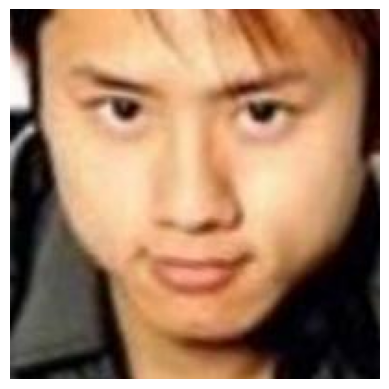

In [6]:
# perform EDA
from PIL import Image
img=Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


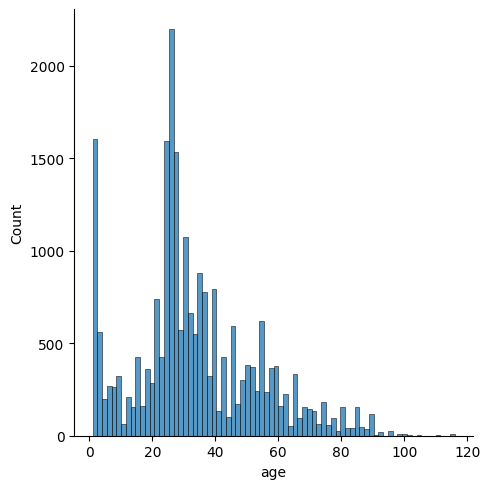

In [7]:
#age distribution
sns.displot(df['age'])

In [8]:
# to display grid of images
plt.figure(figsize=(15,15))
files=df.iloc[0:25]

for index,file,age,gender in files.itertuples():
    plt.subplot(5,5,index+1)
    img=load_img(file)
    img=np.array(img)
    plt.imshow(img)
    plt.title(f"Age:{age} Gender:{gender_dict[gender]}")
    plt.axis("off")


In [9]:
## feature extracrion

def extract_features(images):
    features=[]
    for image in tqdm(images):
        img=load_img(image, color_mode = 'grayscale')
        img=img.resize((128,128),Image.Resampling.LANCZOS)
        img=np.array(img)
        features.append(img)
    features=np.array(features)
    features= features.reshape(len(features),128,128,1) 
    # 1 means grayscale
    #for RGB ignore this last line 
    return features
    

In [10]:
X=extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [11]:
X.shape

(23708, 128, 128, 1)

In [12]:
# normalize the image
X=X/255.0

In [13]:
y_gender=np.array(df['gender'])
y_age=np.array(df['age'])

In [14]:
#model creation

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

input_shape = (128, 128, 1)  # adjust if using RGB

inputs = Input(shape=input_shape)

# Convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)

conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)

conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)

conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

# Fully connected layers
flatten = Flatten()(maxp_4)
dense_1 = Dense(256, activation='relu')(flatten)
dropout_1 = Dropout(0.3)(dense_1)

dense_2 = Dense(256, activation='relu')(dropout_1)
dropout_2 = Dropout(0.3)(dense_2)

# Multi-output heads
output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_2)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

# Define and compile model
model = Model(inputs=inputs, outputs=[output_1, output_2])

model.compile(
    loss={
        'gender_out': 'binary_crossentropy',
        'age_out': 'mae'
    },
    optimizer=Adam(),
    metrics={
        'gender_out': 'accuracy',
        'age_out': 'mae'
    }
)


I0000 00:00:1754022975.905624      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


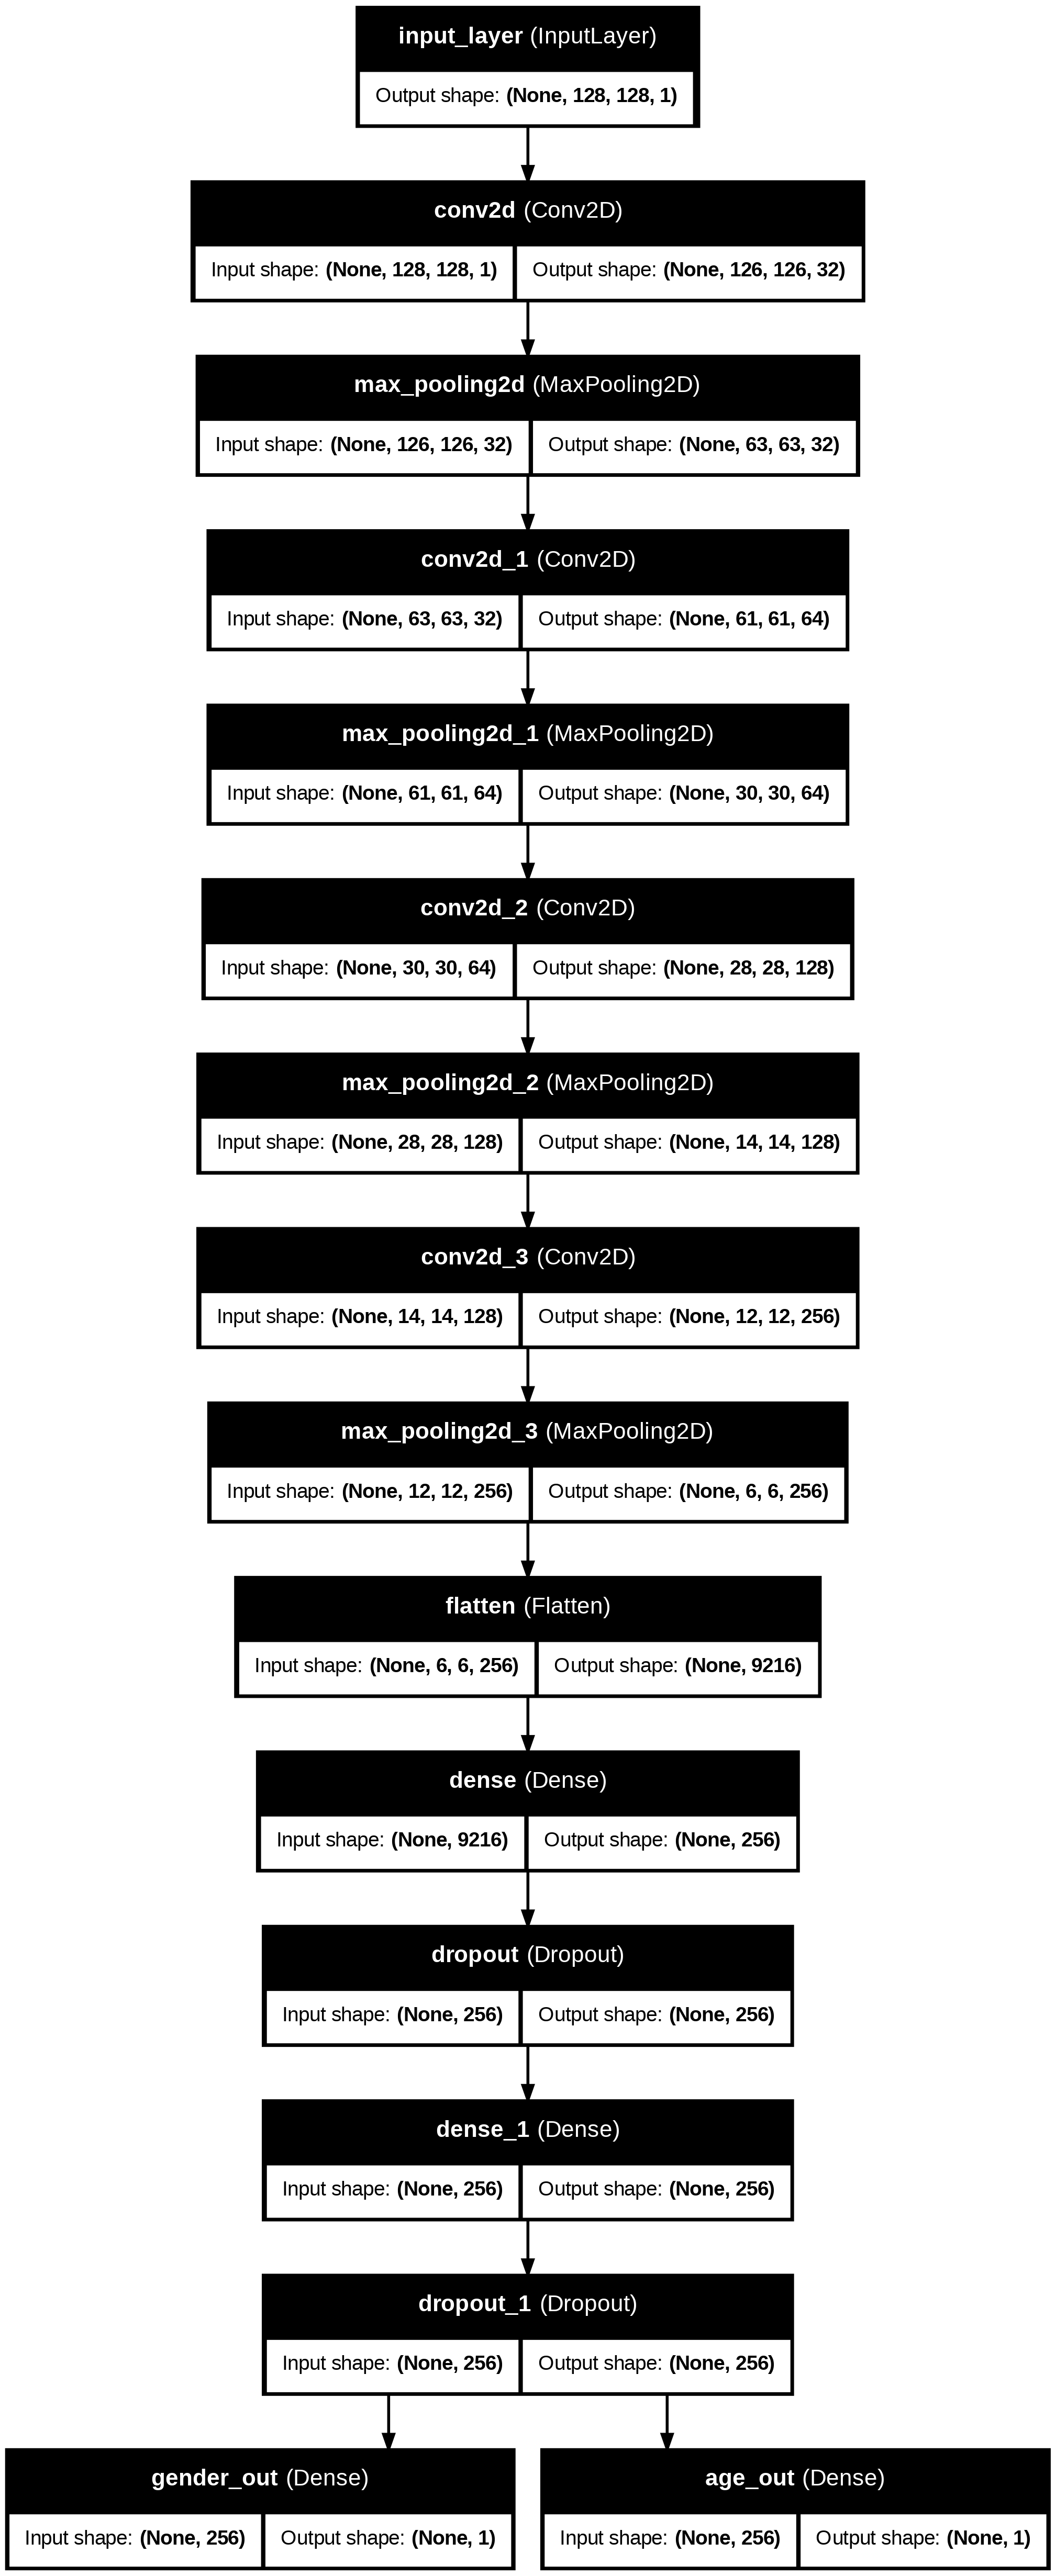

In [15]:
#plot the model
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [16]:
#model tranning
history = model.fit(
    x=X,
    y={'gender_out': y_gender, 'age_out': y_age},
    batch_size=32,
    epochs=30,
    validation_split=0.2
)


Epoch 1/30


I0000 00:00:1754022985.143330      99 service.cc:148] XLA service 0x7aa5cc0155d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754022985.143916      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754022985.597136      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


 16/593 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - age_out_loss: 27.6193 - age_out_mae: 27.6193 - gender_out_accuracy: 0.5313 - gender_out_loss: 1.1679 - loss: 28.7872

I0000 00:00:1754022989.063416      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


593/593 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - age_out_loss: 17.5265 - age_out_mae: 17.5265 - gender_out_accuracy: 0.5018 - gender_out_loss: 1.0378 - loss: 18.5643 - val_age_out_loss: 12.9432 - val_age_out_mae: 12.9015 - val_gender_out_accuracy: 0.6006 - val_gender_out_loss: 0.6511 - val_loss: 13.5525
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - age_out_loss: 12.5086 - age_out_mae: 12.5086 - gender_out_accuracy: 0.6501 - gender_out_loss: 0.6280 - loss: 13.1365 - val_age_out_loss: 9.9321 - val_age_out_mae: 9.9285 - val_gender_out_accuracy: 0.7579 - val_gender_out_loss: 0.5148 - val_loss: 10.4421
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - age_out_loss: 10.2915 - age_out_mae: 10.2915 - gender_out_accuracy: 0.7290 - gender_out_loss: 0.5505 - loss: 10.8421 - val_age_out_loss: 8.5930 - val_age_out_mae: 8.5921 - val_gender_out_accuracy: 0.7967 - val_gender_out_loss: 0.4509 - val_loss: 9.0435
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - age_out_loss: 9.3336 - age_

Text(0.5, 1.0, 'Accuracy Graph')

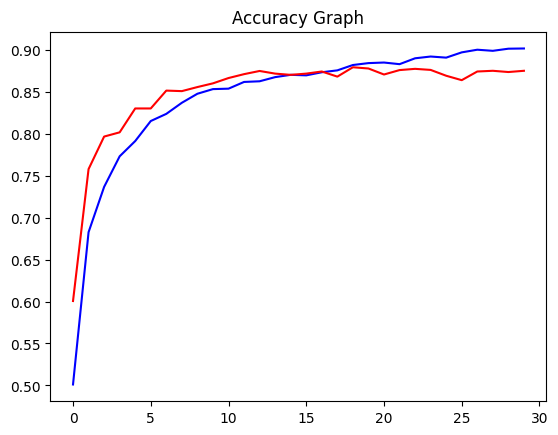

In [17]:
#plot gender accurecy
acc=history.history['gender_out_accuracy']
val_acc=history.history['val_gender_out_accuracy']
epochs=range(len(acc))

plt.plot(epochs,acc,'b',label='Tranning Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.title('Accuracy Graph')

Text(0.5, 1.0, 'Accuracy Graph')

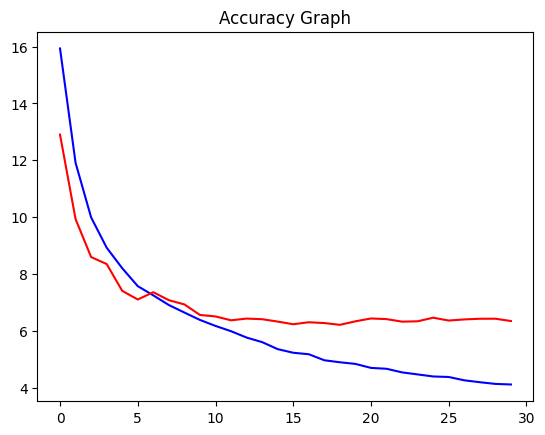

In [18]:
#plot age accurecy
acc=history.history['age_out_mae']
val_acc=history.history['val_age_out_mae']
epochs=range(len(acc))

plt.plot(epochs,acc,'b',label='Tranning Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.title('Accuracy Graph')

In [34]:
model.save("age_gender.h5")

In [20]:
#prediction with test data
image_index=200
pred=model.predict(X[image_index].reshape(1,128,128,1)) #first 1 used bcz it means 1 image
pred_gender=gender_dict[(round(pred[0][0][0]))]
pred_age=round(pred[1][0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


In [21]:
#orginal 
gender_dict[y_gender[image_index]]

'Male'

In [22]:
#orginal 
y_age[image_index]

54

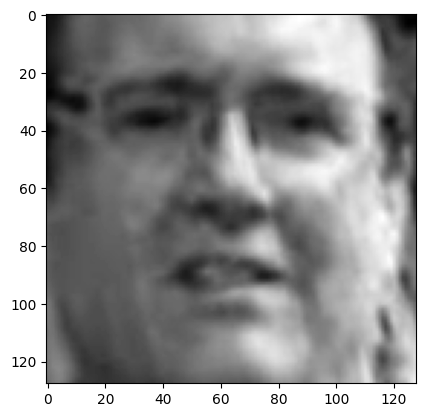

In [23]:
plt.imshow(X[image_index].reshape(128,128),cmap='gray')

In [24]:
#predicted
pred_gender

'Male'

In [25]:
#predicted
pred_age

56